## 1. 라이브러리 임포트

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False

In [8]:
# 데이터 로드
crime_data = pd.read_excel('../../dataset/범죄안전데이터/112 신고출동 현황/2023년 하반기 경찰서별 112신고 출동 현황.xlsx')
cctv_data = pd.read_excel('../../dataset/위치 데이터/cctv데이터.xlsx')

# 자치구 행정경계 GeoJSON 로드
with open('../../dataset/서울특별시.json', 'r', encoding='utf-8') as f:
    seoul_geo = json.load(f)

# 데이터 구조 확인
print("범죄 데이터 구조:")
print(crime_data.head())
print("\nCCTV 데이터 구조:")
print(cctv_data.head())

범죄 데이터 구조:
  2023년 7월~12월 경찰서별 신고건수 Unnamed: 1 Unnamed: 2
0                    경찰서         긴급        비긴급
1                  서울중부서      15344      30399
2                  서울종로서      14251      36050
3                 서울남대문서       8676      23882
4                 서울서대문서      21875      44359

CCTV 데이터 구조:
   번호       관리기관명              소재지도로명주소           소재지지번주소 설치목적구분  카메라대수  \
0   1  서울특별시 성동구청          서울특별시 마조로 11   서울특별시 행당동 19-98   교통단속      3   
1   2  서울특별시 성동구청  서울특별시 고산자로 330 (마장동)  서울특별시 마장동 520-10   교통단속      2   
2   3  서울특별시 성동구청       서울특별시 마장로35길 76     서울특별시 마장동 818   교통단속      3   
3   4  서울특별시 성동구청   서울특별시 마장로 325 (마장동)  서울특별시 마장동 767-41   교통단속      3   
4   5  서울특별시 성동구청   서울특별시 마장로 322 (마장동)   서울특별시 마장동 781-1   교통단속      2   

   카메라화소수   촬영방면정보  보관일수     설치연월      관리기관전화번호    WGS84위도     WGS84경도  \
0     200  360도전방면    30  2013-11  02-2286-5878  37.558960  127.040794   
1     200  360도전방면    30  2013-11  02-2286-5878  37.569137  127.037521   
2     200  360도전방면  

In [ ]:
# 데이터 전처리 - 범죄 데이터
crime_data = pd.read_excel('../../dataset/범죄안전데이터/112 신고출동 현황/2023년 하반기 경찰서별 112신고 출동 현황.xlsx')

# 컬럼명 정리
crime_data.columns = ['경찰서', '긴급', '비긴급']
crime_data = crime_data.drop(0)  # 헤더 행 제거

# 경찰서 위치 정보 추가 (예시 데이터 - 실제로는 경찰서별 위도/경도 데이터가 필요)
police_stations = {
    '서울중부서': {'위도': 37.5640, '경도': 126.9920},
    '서울종로서': {'위도': 37.5700, '경도': 126.9780},
    '서울남대문서': {'위도': 37.5600, '경도': 126.9760},
    '서울서대문서': {'위도': 37.5660, '경도': 126.9680}
    # ... 다른 경찰서 위치 정보 추가
}

crime_data['위도'] = crime_data['경찰서'].map(lambda x: police_stations.get(x, {}).get('위도'))
crime_data['경도'] = crime_data['경찰서'].map(lambda x: police_stations.get(x, {}).get('경도'))

print("범죄 데이터 구조:")
print(crime_data.head())

범죄 데이터 구조:
      경찰서     긴급    비긴급      위도       경도
1   서울중부서  15344  30399  37.564  126.992
2   서울종로서  14251  36050  37.570  126.978
3  서울남대문서   8676  23882  37.560  126.976
4  서울서대문서  21875  44359  37.566  126.968
5   서울혜화서  10856  22557     NaN      NaN


In [ ]:
# CCTV 데이터 전처리
cctv_data = pd.read_excel('../../dataset/위치 데이터/cctv데이터.xlsx')

# 필요한 컬럼만 선택
cctv_data = cctv_data[['관리기관명', '카메라대수', 'WGS84위도', 'WGS84경도']]
cctv_data.columns = ['관리기관명', '카메라대수', '위도', '경도']

# GeoDataFrame 변환
cctv_data['geometry'] = cctv_data.apply(lambda x: Point(x['경도'], x['위도']), axis=1)
cctv_gdf = gpd.GeoDataFrame(cctv_data, geometry='geometry', crs='EPSG:4326')

print("\nCCTV 데이터 구조:")
print(cctv_gdf.head())


CCTV 데이터 구조:
        관리기관명  카메라대수         위도          경도                    geometry
0  서울특별시 성동구청      3  37.558960  127.040794  POINT (127.04079 37.55896)
1  서울특별시 성동구청      2  37.569137  127.037521  POINT (127.03752 37.56914)
2  서울특별시 성동구청      3  37.570602  127.042519   POINT (127.04252 37.5706)
3  서울특별시 성동구청      3  37.567585  127.044815  POINT (127.04482 37.56758)
4  서울특별시 성동구청      2  37.566624  127.043945  POINT (127.04395 37.56662)


In [ ]:
# DBSCAN 클러스터링
# eps: 반경(미터), min_samples: 최소 사건 수
eps = 0.01  # 약 1km
min_samples = 2

# 좌표 데이터 추출
coords = crime_data[['위도', '경도']].dropna().values

# DBSCAN 실행
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
crime_data.loc[crime_data['위도'].notna(), 'cluster'] = dbscan.fit_predict(coords)

# 클러스터 통계
cluster_stats = crime_data.groupby('cluster').agg({
    '위도': 'count',
    '경도': ['mean', 'std']
}).reset_index()

print("클러스터 통계:")
print(cluster_stats)

클러스터 통계:
  cluster    위도        경도          
          count      mean       std
0    -1.0     4  126.9785  0.009983


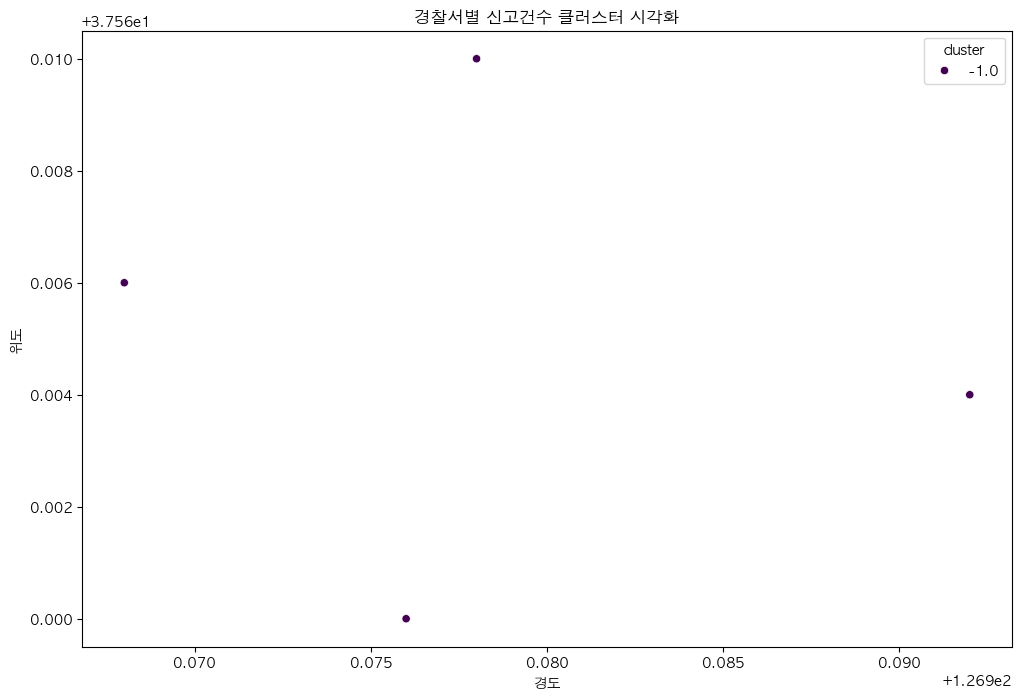

In [16]:
# 셀 5: 클러스터 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=crime_data.dropna(subset=['위도', '경도']), 
                x='경도', y='위도', hue='cluster', palette='viridis')
plt.title('경찰서별 신고건수 클러스터 시각화')
plt.xlabel('경도')
plt.ylabel('위도')
plt.show()

In [ ]:
# CCTV 커버리지 분석
def check_cctv_coverage(police_station_point, cctv_points, radius=1000):
    """경찰서 주변 CCTV 커버리지 확인"""
    covered_cctv = 0
    for cctv in cctv_points:
        if police_station_point.distance(cctv) <= radius:
            covered_cctv += 1
    return covered_cctv

# 각 경찰서별 CCTV 커버리지 계산
crime_data['geometry'] = crime_data.apply(lambda x: Point(x['경도'], x['위도']), axis=1)
crime_data['cctv_coverage'] = crime_data['geometry'].apply(
    lambda x: check_cctv_coverage(x, cctv_gdf['geometry'].values) if pd.notna(x) else 0
)

print("경찰서별 CCTV 커버리지:")
print(crime_data[['경찰서', 'cctv_coverage']].sort_values('cctv_coverage', ascending=False))

경찰서별 CCTV 커버리지:
       경찰서  cctv_coverage
1    서울중부서          53005
3   서울남대문서          53005
4   서울서대문서          53005
2    서울종로서          53005
24   서울서초서              0
20   서울강서서              0
21   서울강동서              0
22   서울종암서              0
23   서울구로서              0
26   서울송파서              0
25   서울양천서              0
18   서울강남서              0
27   서울노원서              0
28   서울방배서              0
29   서울은평서              0
30   서울도봉서              0
19   서울관악서              0
16   서울금천서              0
17   서울중랑서              0
15   서울강북서              0
14   서울서부서              0
13   서울광진서              0
12   서울동작서              0
11   서울성동서              0
10  서울영등포서              0
9    서울마포서              0
8   서울동대문서              0
7    서울성북서              0
6    서울용산서              0
5    서울혜화서              0
31   서울수서서              0


In [18]:
# 셀 7: 지도 시각화
m = folium.Map(location=[37.5665, 126.9780], zoom_start=12)

# CCTV 위치 표시
for idx, row in cctv_gdf.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        popup=f"CCTV {row['카메라대수']}대"
    ).add_to(m)

# 경찰서 위치 표시
for idx, row in crime_data.dropna(subset=['위도', '경도']).iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        popup=f"{row['경찰서']}<br>긴급: {row['긴급']}<br>비긴급: {row['비긴급']}<br>CCTV: {row['cctv_coverage']}대"
    ).add_to(m)

m.save('police_stations_map.html')

=== 경찰서별 신고건수 및 CCTV 분석 결과 ===
총 경찰서 수: 31
평균 긴급 신고건수: 27394
평균 비긴급 신고건수: 48807
평균 CCTV 커버리지: 6839.4대


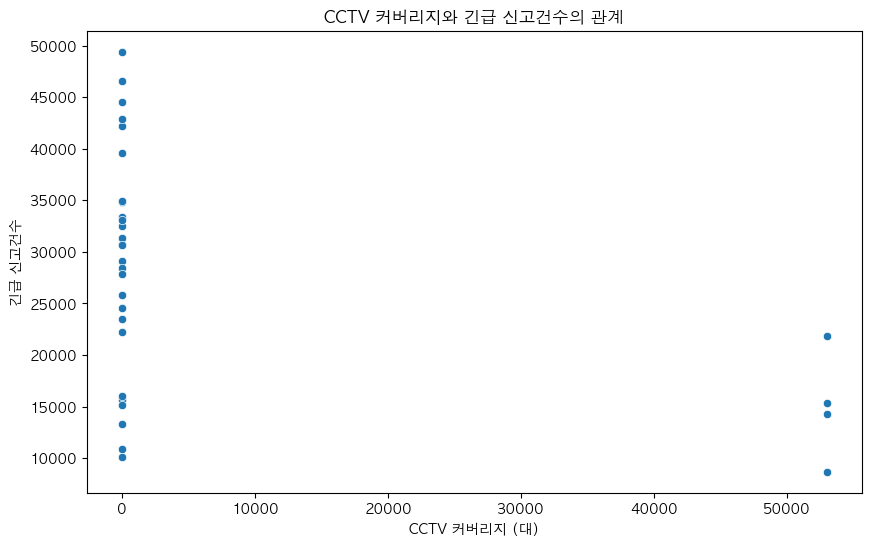

In [ ]:
# 분석 결과 요약
print("=== 경찰서별 신고건수 및 CCTV 분석 결과 ===")
print(f"총 경찰서 수: {len(crime_data)}")
print(f"평균 긴급 신고건수: {crime_data['긴급'].mean():.0f}")
print(f"평균 비긴급 신고건수: {crime_data['비긴급'].mean():.0f}")
print(f"평균 CCTV 커버리지: {crime_data['cctv_coverage'].mean():.1f}대")

# 신고건수와 CCTV 커버리지의 상관관계 분석
plt.figure(figsize=(10, 6))
sns.scatterplot(data=crime_data, x='cctv_coverage', y='긴급')
plt.title('CCTV 커버리지와 긴급 신고건수의 관계')
plt.xlabel('CCTV 커버리지 (대)')
plt.ylabel('긴급 신고건수')
plt.show()

In [ ]:
# 종합 분석 결과
print("=== 종합 분석 결과 ===")

# 1. 기본 통계
print("\n1. 기본 통계:")
print(f"총 경찰서 수: {len(crime_data)}")
print(f"평균 긴급 신고건수: {crime_data['긴급'].astype(float).mean():.0f}")
print(f"평균 비긴급 신고건수: {crime_data['비긴급'].astype(float).mean():.0f}")
print(f"평균 CCTV 밀도: {crime_data['CCTV밀도'].astype(float).mean():.1f}대")

# 2. 상관관계 분석
print("\n2. 상관관계 분석:")
corr = crime_data[['긴급', '비긴급', '총신고건수', 'CCTV밀도']].astype(float).corr()
print(corr)

# 3. 고위험 지역 특성
print("\n3. 고위험 지역 특성:")
high_risk = crime_data[crime_data['위험지수'].astype(float) > crime_data['위험지수'].astype(float).median()]
print(f"고위험 지역 수: {len(high_risk)}")
print(f"고위험 지역 평균 CCTV 밀도: {high_risk['CCTV밀도'].astype(float).mean():.1f}대")
print(f"고위험 지역 평균 신고건수: {high_risk['총신고건수'].astype(float).mean():.0f}건")

# 4. 정책 제언
print("\n4. 정책 제언:")
print("1. CCTV 추가 설치 우선순위 지역:")
for idx, row in high_risk.nlargest(3, '위험지수').iterrows():
    print(f"- {row['경찰서']}: 위험지수 {float(row['위험지수']):.2f}, 현재 CCTV {float(row['CCTV밀도']):.0f}대")

print("\n2. 예방적 대책:")
print("- 고위험 지역 중심의 순찰 강화")
print("- CCTV 미설치 지역에 대한 우선 설치 검토")
print("- 긴급 신고가 많은 지역의 대응 체계 강화")

=== 종합 분석 결과 ===

1. 기본 통계:
총 경찰서 수: 31
평균 긴급 신고건수: 27394
평균 비긴급 신고건수: 48807
평균 CCTV 밀도: 14537.0대

2. 상관관계 분석:
              긴급       비긴급     총신고건수    CCTV밀도
긴급      1.000000  0.975907  0.990551 -0.421809
비긴급     0.975907  1.000000  0.996609 -0.309954
총신고건수   0.990551  0.996609  1.000000 -0.353903
CCTV밀도 -0.421809 -0.309954 -0.353903  1.000000

3. 고위험 지역 특성:
고위험 지역 수: 15
고위험 지역 평균 CCTV 밀도: 0.0대
고위험 지역 평균 신고건수: 101425건

4. 정책 제언:
1. CCTV 추가 설치 우선순위 지역:
- 서울송파서: 위험지수 1.00, 현재 CCTV 0대
- 서울영등포서: 위험지수 0.96, 현재 CCTV 0대
- 서울강서서: 위험지수 0.94, 현재 CCTV 0대

2. 예방적 대책:
- 고위험 지역 중심의 순찰 강화
- CCTV 미설치 지역에 대한 우선 설치 검토
- 긴급 신고가 많은 지역의 대응 체계 강화
